<a href="https://colab.research.google.com/github/likeshd/time_series_models_libraries/blob/main/time_series_sarima_prophet_xgboost_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pmdarima
!pip install prophet
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("/content/time_series_covid19_deaths_global.csv")
data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,67,70,75,78,80,80,80,86,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,94,96,97,100,104,105,106,106,108,110
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,512,512,515,518,523,528,528,528,528,530
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,200,203,235,241,241,246,246,256,260,260


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 212 entries, Province/State to 8/16/20
dtypes: float64(2), int64(208), object(2)
memory usage: 440.7+ KB


In [36]:
#data for the daily deaths in all countries
daily_data = data.loc[:, '1/22/20':]
daily_data

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,0,0,0,0,0,0,0,0,0,0,...,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,0,0,0,0,0,0,0,0,0,0,...,189,193,199,200,205,208,213,219,225,228
2,0,0,0,0,0,0,0,0,0,0,...,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,53,53,53,53,53
4,0,0,0,0,0,0,0,0,0,0,...,67,70,75,78,80,80,80,86,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0,0,0,0,0,0,0,0,0,0,...,94,96,97,100,104,105,106,106,108,110
262,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
263,0,0,0,0,0,0,0,0,0,0,...,512,512,515,518,523,528,528,528,528,530
264,0,0,0,0,0,0,0,0,0,0,...,200,203,235,241,241,246,246,256,260,260


In [37]:
#transpose dataframe
daily_data_transpose = daily_data.transpose()
daily_data_transpose.head()

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
daily_data_sum= daily_data_transpose.sum(axis =1)
daily_data_sum

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
8/12/20    743989
8/13/20    750230
8/14/20    760374
8/15/20    765718
8/16/20    769904
Length: 208, dtype: int64

In [40]:
daily_list= daily_data_sum.to_list()
daily_list[:10]

[17, 18, 26, 42, 56, 82, 131, 133, 171, 213]

In [41]:
#create new dataframe
dataset = pd.DataFrame(columns=['ds', 'y'])
dataset.head()

,ds,y


Get the dates from the columns in `deaths_df` data frame, starting from the fifth column. They will be obtained in string format.

In [44]:
dates  = list(data.columns[4:])
dates[:10]

['1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20']

In [45]:
dates = list(pd.to_datetime(dates))
dates[:10]

[Timestamp('2020-01-22 00:00:00'),
 Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-26 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-01-28 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-30 00:00:00'),
 Timestamp('2020-01-31 00:00:00')]

In [51]:
dataset["ds"] = dates
dataset["y"]= daily_list
dataset

,y,ds
ds,,
2020-01-22,17,2020-01-22
2020-01-23,18,2020-01-23
2020-01-24,26,2020-01-24
2020-01-25,42,2020-01-25
2020-01-26,56,2020-01-26
...,...,...
2020-08-12,743989,2020-08-12
2020-08-13,750230,2020-08-13
2020-08-14,760374,2020-08-14


In [63]:
covid_data = dataset.set_index('ds')
covid_data

,y
ds,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56
...,...
2020-08-12,743989
2020-08-13,750230
2020-08-14,760374


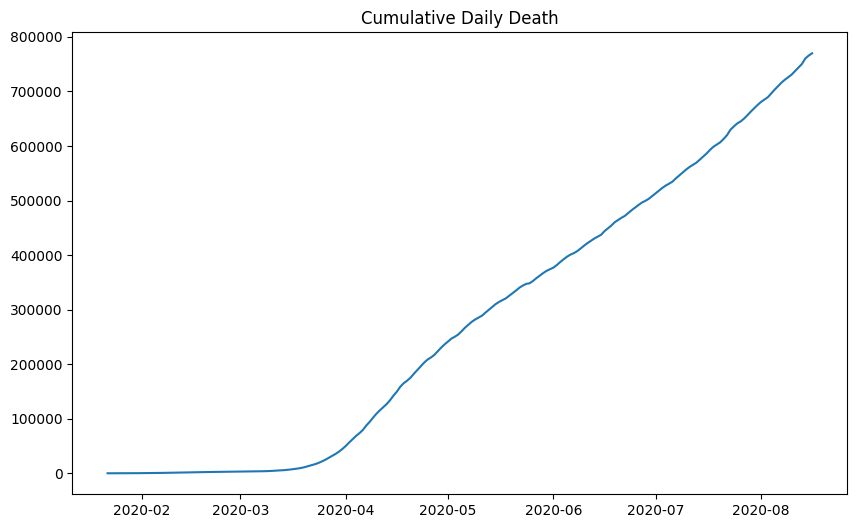

In [64]:
# Let's plot the daily number of casulties
#plot
plt.figure(figsize=(10, 6))
plt.plot(covid_data)
plt.title('Cumulative Daily Death')
plt.savefig('Cumulative Daily Death',
           bbox_inches='tight',
           transparent=False)


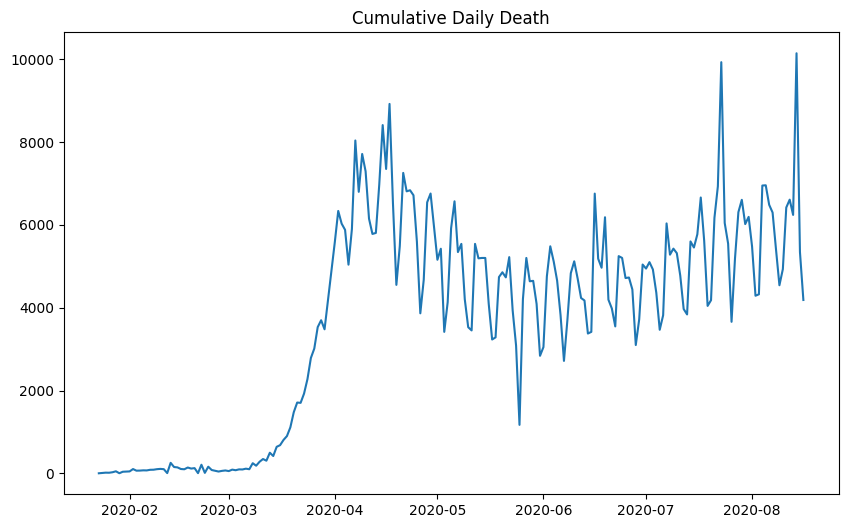

In [65]:
# Let's plot the daily number of casulties
#plot
plt.figure(figsize=(10, 6))
plt.plot(covid_data.diff())
plt.title('Cumulative Daily Death')
#save
# plt.savefig('Cumulative Daily Death',bbox_inches='tight',transparent=False)


In [66]:
#convert dataset into diff dataset
covid_data1 = covid_data.diff() #difference between present and past
covid_data1

,y
ds,
2020-01-22,NaN
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
...,...
2020-08-12,6609.0
2020-08-13,6241.0
2020-08-14,10144.0


In [67]:
data1 = covid_data1.loc['2020-01-23':'2020-08-13']
data1

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
...,...
2020-08-09,4542.0
2020-08-10,4931.0
2020-08-11,6419.0


## SARIMAX Model
Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors Model)
SARIMAX is one of the time series models in the python statistics library statsmodels.

But before we apply the model, we will split our dataset into a training and test sets. We will do this by taking all dates prior to 31st of July as training set, on which the model will be optimized, and all dates from 31st July as the test set, on which we will test the accuracy of the predictions that the optimized model will make.

In [70]:
#set start date
split_date = '2020-07-31'

#define train and test set
train = data1.loc[data1.index < pd.to_datetime(split_date)] #index is date
test = data1.loc[data1.index >= pd.to_datetime(split_date)] #index is date

Now let's talk about SARIMAX. There are three hyperparameters that go into the order tuple: p, q and d. Here we've used p=2, q=1 and d=3.

In [72]:
#create model
model = SARIMAX(train, order=(2, 1, 3))
model

Next, we call the fit method to optimize the model.

In [74]:
#fit
results = model.fit(disp=True)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  190
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1506.424
Date:                Thu, 04 Apr 2024   AIC                           3024.848
Time:                        11:20:18   BIC                           3044.298
Sample:                    01-23-2020   HQIC                          3032.728
                         - 07-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2434      0.017     72.427      0.000       1.210       1.277
ar.L2         -0.9796      0.019    -51.211      0.000      -1.017      -0.942
ma.L1         -1.7687      0.065    -27.197      0.000      -1.896      -1.641
ma.L2          1.4754      0.097     15.267      0.000       1.286       1.665
ma.L3         -0.3939      0.064     -6.142      0.000      -0.520      -0.268
sigma2      4.964e+05   3.61e+04     13.750      0.000    4.26e+05    5.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                95.44
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              13.70   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now let's make predictions using the model, and compare those against the values in the test set.

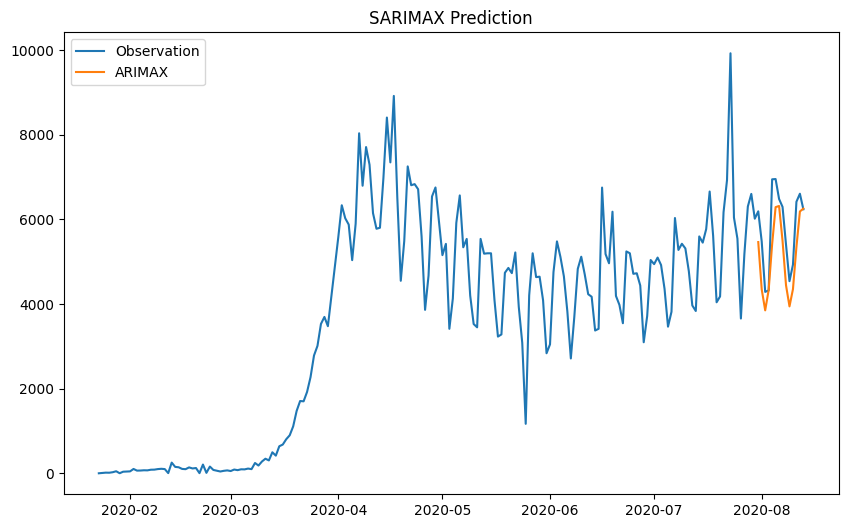

In [77]:
#predict
sarimax_prediction = results.predict(start=split_date,
                                    end='2020-08-13',
                                    dynamic=False)

#plot prediction
plt.figure(figsize=(10, 6))
l1, = plt.plot(data1, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMAX')
plt.title('SARIMAX Prediction')
plt.legend(handles=[l1, l2])

#save
# plt.savefig('SARIMAX Prediction', bbox_inches='tight', transparent=False)

In [78]:
#get MAE
print('SARIMAX MAE:', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE: 650.6235427681095


However, in a typical machine learning workflow, we should find the best values of p, q and r that will minimize the error. We can use the auto_arima function in the pmdarima module to do that. This will find the optimal parameter combintation and return the best model.

In [79]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3111.971, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.421, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3128.118, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3089.597, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3116.490, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.794, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.309, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.720, Time=1.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=1.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

## Facebook's Prophet Model
This is the open source time series library released by Facebook. It is also widely used by Facebook in their own time series analysis tasks. Facebook prophet does not require that you specify or search for hyperparameters. The model can act as a black box that does all the required computations on its own. And it works with the same object-fit-predict API.

Prophet expects the data frame to have 2 columns, unlike SARIMAX.

In [82]:
train['ds'] = train.index.values

Then we create a new Prophet object and call the fit() method

In [94]:
#create object
p = Prophet()

#fit
p.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnw3i1in/iypcgsty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnw3i1in/helgw879.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64418', 'data', 'file=/tmp/tmpfnw3i1in/iypcgsty.json', 'init=/tmp/tmpfnw3i1in/helgw879.json', 'output', 'file=/tmp/tmpfnw3i1in/prophet_modelnf_ukvuz/prophet_model-20240404114605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [97]:
# Now let's forecast:
future = p.make_future_dataframe(periods=data1.shape[0] - train.shape[0])

prophet_prediction = p.predict(future)

Now let us calculate the mean absolute error for our predictions.

In [98]:
prophet_prediction = prophet_prediction.set_index('ds')

prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= split_date ]

print('Prophet MAE:', mean_absolute_error(prophet_future, test))

Prophet MAE: 572.5434673600681


Next, let's visualize the predictions

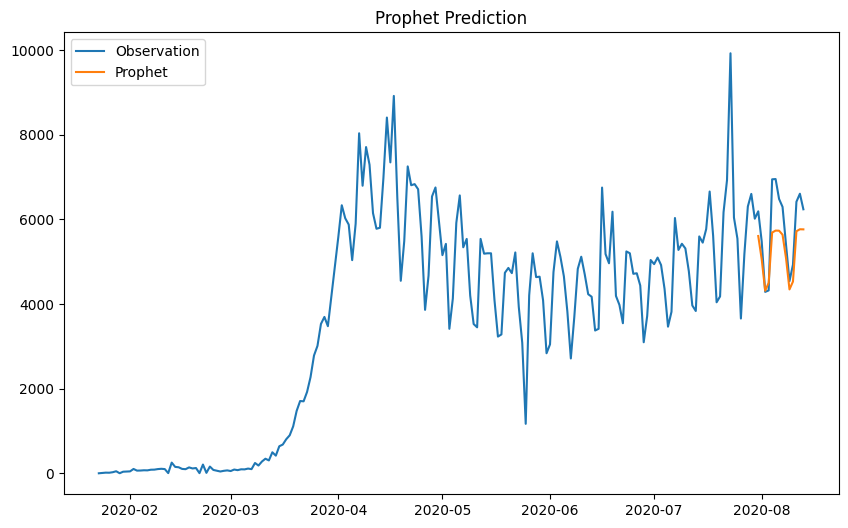

In [100]:
#plot
plt.figure(figsize=(10, 6))
l1, = plt.plot(data1, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.title('Prophet Prediction')
plt.legend(handles=[l1, l2])

#save
# plt.savefig('Prophet Prediction', bbox_inches='tight', transparent=False)

## Preparing the dataset for XGBOOST and NN
Unlike the prophet and SAIMAX models, the two models we will train in Task 6, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [106]:
#extract features
def featurize(t):

    X = pd.DataFrame()
    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear


    y = t.y
    return X, y

In [109]:
#preview
featurize(data1)[0].head()

,day,month,quarter,dayofweek,dayofyear
0,23,1,1,3,23
1,24,1,1,4,24
2,25,1,1,5,25
3,26,1,1,6,26
4,27,1,1,0,27


Preprocessing Data
In this task we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.


In [110]:
#train test split
X_train, y_train = featurize(data1.loc[data1.index < pd.to_datetime(split_date)])
X_test, y_test = featurize(data1.loc[data1.index >= pd.to_datetime(split_date)])

Now let's discuss data normalization. We perform data normalization so as to make the range of values of the features, or the columns in the X_train table, as close as possible. For example, we have the features dayofweek and dayofyear. The range of values of dayofweek is from 1 to 7, whereas dayofyear is from 1 to 365. Having such large differences in the ranges of values will either slow down the training of the machine learning model or make it quite difficult. We solve this problem by applying normalization. There are several ways we can normalize the data with. Here I will choose the StandardScaler, which applies the following equation on each of the columns.

z = (x - u) / s

Here x is the column before scaling, u is thee mean and s is the standard deviation. So basically, we subtract the mean of each column from itself, then divide by the standard deviation of that column. To apply StandardScaler, we first fit the scaler object to the dataset:

In [111]:
#initialize
scaler = StandardScaler()

#fit
scaler.fit(X_train)

StandardScaler()

Apply the scaling to both the training and test sets, as follows.

In [112]:
#transform
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

## Train the XGBOOST and NN models
First, create the XGBRegressor object which will represent the XGBOOST regression model

In [113]:
#create model
xgboost_model = XGBRegressor(n_estimators=7)

Next, train the XGBOOST regression model using the fit method, and perform prediction using the predict method.

In [114]:
#fit
xgboost_model.fit(scaled_train, y_train,
                 eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                 verbose=True)

#predict
xgboost_prediction = xgboost_model.predict(scaled_test)

[0]	validation_0-rmse:1835.75343	validation_1-rmse:1771.35674
[1]	validation_0-rmse:1349.05090	validation_1-rmse:1269.42755
[2]	validation_0-rmse:1008.53134	validation_1-rmse:943.84902
[3]	validation_0-rmse:773.31185	validation_1-rmse:779.35136
[4]	validation_0-rmse:600.37666	validation_1-rmse:656.69108
[5]	validation_0-rmse:484.66288	validation_1-rmse:463.57152
[6]	validation_0-rmse:393.98163	validation_1-rmse:410.33551


Let us calculate the mean absolute error for the training.


In [115]:
print('XG-Boost MAE:', mean_absolute_error(xgboost_prediction, y_test))

XG-Boost MAE: 347.8701869419643


Creation and training of the feedforward neural network model.

In [116]:
#neural architect
nn_model = Sequential()
nn_model.add(Dense(20, input_shape=(scaled_train.shape[1],)))
nn_model.add(Dense(10))
nn_model.add(Dense(1))

#compile
nn_model.compile(loss='mean_absolute_error',
                optimizer=Adam(lr=0.001))

#fit
nn_model.fit(scaled_train, y_train,
            validation_data=(scaled_test, y_test),
            epochs=220,
            verbose=1)

#predict
nn_prediction = nn_model.predict(scaled_test)

Epoch 1/220
6/6 [==============================] - 2s 69ms/step - loss: 3521.5349 - val_loss: 5795.0264
Epoch 2/220
6/6 [==============================] - 0s 20ms/step - loss: 3521.4724 - val_loss: 5794.9517
Epoch 3/220
6/6 [==============================] - 0s 17ms/step - loss: 3521.4177 - val_loss: 5794.8857
Epoch 4/220
6/6 [==============================] - 0s 13ms/step - loss: 3521.3621 - val_loss: 5794.8081
Epoch 5/220
6/6 [==============================] - 0s 13ms/step - loss: 3521.3037 - val_loss: 5794.7915
Epoch 6/220
6/6 [==============================] - 0s 14ms/step - loss: 3521.2427 - val_loss: 5794.7031
Epoch 7/220
6/6 [==============================] - 0s 16ms/step - loss: 3521.1763 - val_loss: 5794.6475
Epoch 8/220
6/6 [==============================] - 0s 14ms/step - loss: 3521.1057 - val_loss: 5794.5586
Epoch 9/220
6/6 [==============================] - 0s 14ms/step - loss: 3521.0310 - val_loss: 5794.5190
Epoch 10/220
6/6 [==============================] - 0s 14ms/step

Let's compare the MAE values.

In [117]:
print('XG-Boost MAE:', mean_absolute_error(xgboost_prediction, y_test))
print('Prophet MAE:', mean_absolute_error(prophet_future, test))
print('SARIMAX MAE:', mean_absolute_error(sarimax_prediction, test))
print('Neural Net MAE:', mean_absolute_error(nn_prediction, test))

XG-Boost MAE: 347.8701869419643
Prophet MAE: 572.5434673600681
SARIMAX MAE: 650.6235427681095
Neural Net MAE: 734.1302664620536


Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

<Figure size 3000x3000 with 0 Axes>

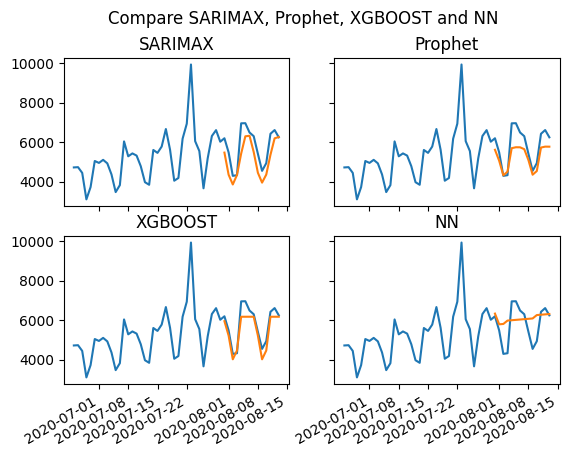

In [119]:
xgboost_df = pd.DataFrame({'y': xgboost_prediction.tolist()})
xgboost_df.index = y_test.index

nn_df = pd.DataFrame(nn_prediction)
nn_df.index = y_test.index
plt.figure(figsize=(30, 30))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, Prophet, XGBOOST and NN')
axs[0, 0].plot(data1.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data1.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data1.tail(50))
axs[1, 0].plot(xgboost_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data1.tail(50))
axs[1, 1].plot(nn_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)